In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential([layers.Dense(ff_dim, activation = "relu"), layers.Dense(embed_dim),])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs, inputs)
        attn_output = self.dropout1(attn_output, training = training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training = training)
        return self.layernorm2(out1 + ffn_output)

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [3]:
class Encoder(layers.Layer):
    def __init__(self, embed_dim, num_layers, num_heads, ff_dim, rate =0.1):
        super(Encoder, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.transformer_layers = [TransformerBlock(embed_dim,
                                                    num_heads,
                                                    rate = rate,
                                                    ff_dim = ff_dim) for _ in range(num_layers)]
    def call(self, x):
        inputs = x
        for layer in self.transformer_layers:
            out = layer(inputs)
            inputs = out 
        return out

In [4]:
class Decoder(layers.Layer):
    def __init__(self, embed_dim, num_layers, num_heads, ff_dim, rate=0.1):
        super(Decoder, self).__init__()
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(num_heads=num_heads,
                                                     key_dim=embed_dim)
        self.attention_2 = layers.MultiHeadAttention(num_heads=num_heads,
                                                     key_dim=embed_dim)
        self.dense_proj = keras.Sequential([layers.Dense(ff_dim, activation="relu"),
                                            layers.Dense(embed_dim),])
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat([tf.expand_dims(batch_size, -1), 
                          tf.constant([1, 1], dtype=tf.int32)],
                          axis=0,)
        return tf.tile(mask, mult)

    def call(self, inputs, encoder_outputs, mask=None):
        for _ in range(num_layers):
            casual_mask = self.get_causal_attention_mask(inputs)
            
            if mask is not None:
                padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
                padding_mask = tf.minimum(padding_mask, casual_mask)
            
            else:
                padding_mask = None
            attention_output_1 = self.attention_1(query = inputs,
                                                  value = inputs,
                                                  key = inputs, 
                                                  attention_mask=casual_mask)
            
            out_1 = self.layernorm_1(inputs + attention_output_1)

            attention_output_2 = self.attention_2(query = out_1,
                                                  value = encoder_outputs,
                                                  key = encoder_outputs,
                                                  attention_mask = padding_mask,)
            
            out_2 = self.layernorm_2(out_1 + attention_output_2)

            proj_output = self.dense_proj(out_2)
            out = self.layernorm_3(out_2 + proj_output)
            inputs = out
        return out

In [5]:
import pandas as pd
import numpy as np

dataset = pd.read_csv('eng-spa.txt', sep='\t', header=None)
dataset = dataset.iloc[:,0:2]

source_tokens = []
for sentence in dataset.iloc[:,0]:
    source_tokens.append(sentence.lower().split(' '))

target_tokens = []
for sentence in dataset.iloc[:,1]:
    target_tokens.append(sentence.lower().split(' '))
    
def build_token_dict(token_list):
    token_dict = {'<TOKEN_NULO>': 0,'<TOKEN_INICIO>': 1,'<TOKEN_FIN>': 2}
    for tokens in token_list:
        for token in tokens:
            if token not in token_dict:
                token_dict[token] = len(token_dict)
    return token_dict


source_token_dict = build_token_dict(source_tokens)
target_token_dict = build_token_dict(target_tokens)


# DICCIONARIO PARA LA TRADUCCIÓN (para programa que genera la traducción): de número a token
target_token_dict_inv = {v:k for k,v in target_token_dict.items()}
source_token_dict_inv = {v:k for k,v in source_token_dict.items()}

# Agregar inicio, fin y vacío a cada frase
# Corpus Inglés + inicio-fin
encoder_tokens = [['<TOKEN_INICIO>'] + tokens + ['<TOKEN_FIN>'] for tokens in source_tokens]
# Corpus Español + inicio-fin
decoder_tokens = [['<TOKEN_INICIO>'] + tokens + ['<TOKEN_FIN>'] for tokens in target_tokens]
# Corpus como debería ser la salida + fin (para la salida del modelo)
output_tokens = [tokens + ['<TOKEN_FIN>'] for tokens in target_tokens]

source_max_len = max(map(len, encoder_tokens))
target_max_len = max(map(len, decoder_tokens))

max_len = max(source_max_len,target_max_len)

encoder_tokens = [tokens + ['<TOKEN_NULO>']*(max_len-len(tokens)) for tokens in encoder_tokens]
decoder_tokens = [tokens + ['<TOKEN_NULO>']*(max_len-len(tokens)) for tokens in decoder_tokens]
output_tokens = [tokens + ['<TOKEN_NULO>']*(max_len-len(tokens)) for tokens in output_tokens ]

encoder_input = [list(map(lambda x: source_token_dict[x], tokens)) for tokens in encoder_tokens]
decoder_input = [list(map(lambda x: target_token_dict[x], tokens)) for tokens in decoder_tokens]
output_decoder = [list(map(lambda x: target_token_dict[x], tokens)) for tokens in output_tokens]

# ENTRADAS
x1 = np.array(encoder_input)#astype('float32')
x2 = np.array(decoder_input)#.astype('float32')

# SALIDA
y = np.array(output_decoder)#.astype('float32')

In [6]:
from sklearn.model_selection import train_test_split
z = [1, 2, 3, 4, 5]
x = [2, 4, 6, 8, 10]
yp = [-3, 1, -2, -1, 0]
ztr, zte, yt1, yte1 = train_test_split(z, yp, random_state=73)
xtr, xte, yt2, yte2 = train_test_split(x, yp, random_state=73)

In [7]:
yt1 == yt2, yte1 == yte2

(True, True)

In [8]:
x1_train, x1_test, y_train, y_test = train_test_split(x1, y, train_size = 0.7, random_state = 73)
x2_train, x2_test, y_train, y_test = train_test_split(x2, y, train_size = 0.7, random_state = 73)

In [9]:
len(target_token_dict)

29638

In [31]:
#HYPERMARAMETERS
batch_size = 64
epochs = 5
embed_dim = 256
num_layers = 4
num_heads = 3
ff_dim = 1024


source_vocab_size = len(source_token_dict)
target_vocab_size = len(target_token_dict)
encoder_input = decoder_input = max_len

#MODEL

encoder_inputs = keras.Input(shape=(max_len, ), dtype="int32", name="encoder_inputs")

x = TokenAndPositionEmbedding(max_len, source_vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = Encoder(embed_dim = embed_dim,
                          num_layers = num_layers,
                          num_heads = num_heads,
                          ff_dim = ff_dim
                          )(x)

encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=(max_len,), dtype="int32", name="decoder_inputs")

encoded_seq_inputs = keras.Input(shape=(max_len, embed_dim, ), dtype="float32",name="decoder_state_inputs")

x = TokenAndPositionEmbedding(max_len, target_vocab_size, embed_dim)(decoder_inputs)
x = Decoder(embed_dim = embed_dim, 
            num_layers = num_layers,
            num_heads = num_heads, 
            ff_dim = ff_dim
            )(x, encoded_seq_inputs)

x = layers.Dropout(0.1)(x)

decoder_outputs = layers.Dense(target_vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder_outputs])

transformer = keras.Model(inputs = [encoder_inputs, decoder_inputs], 
                          outputs = decoder_outputs,
                          name = "transformer")
transformer.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_inputs (InputLayer)    [(None, 17)]         0           []                               
                                                                                                  
 token_and_position_embedding_4  (None, 17, 256)     4273664     ['encoder_inputs[0][0]']         
  (TokenAndPositionEmbedding)                                                                     
                                                                                                  
 decoder_inputs (InputLayer)    [(None, 17)]         0           []                               
                                                                                                  
 encoder_2 (Encoder)            (None, 17, 256)      5262336     ['token_and_position_em

In [11]:
%%time
from tensorflow.keras.callbacks import LearningRateScheduler
import math

def step_decay(epoch):
   lrate = 1e-4
   return lrate

#optimizer = tf.keras.optimizers.Adam(learning_rate = CustomSchedule(embed_dim, 1e-2),
#                                      name='Adam')
callbacks = [LearningRateScheduler(step_decay)]
transformer.compile(optimizer="adam",
                    loss="sparse_categorical_crossentropy", 
                    metrics=["accuracy"])

history = transformer.fit([x1_train, x2_train], y_train, 
                          batch_size = batch_size, 
                          epochs = epochs, 
                          validation_data = [[x1_test, x2_test], y_test],
                          callbacks = callbacks)

Epoch 1/5
922/922 [==============================] - 147s 143ms/step - loss: 2.9103 - accuracy: 0.7110 - val_loss: 1.7537 - val_accuracy: 0.7664 - lr: 1.0000e-04
Epoch 2/5
922/922 [==============================] - 129s 140ms/step - loss: 1.5259 - accuracy: 0.7898 - val_loss: 1.3921 - val_accuracy: 0.8078 - lr: 1.0000e-04
Epoch 3/5
922/922 [==============================] - 130s 141ms/step - loss: 1.2306 - accuracy: 0.8220 - val_loss: 1.2031 - val_accuracy: 0.8283 - lr: 1.0000e-04
Epoch 4/5
922/922 [==============================] - 129s 140ms/step - loss: 1.0310 - accuracy: 0.8456 - val_loss: 1.0741 - val_accuracy: 0.8465 - lr: 1.0000e-04
Epoch 5/5
922/922 [==============================] - 129s 140ms/step - loss: 0.8769 - accuracy: 0.8658 - val_loss: 0.9863 - val_accuracy: 0.8585 - lr: 1.0000e-04
CPU times: user 6min 41s, sys: 26.4 s, total: 7min 8s
Wall time: 11min 36s


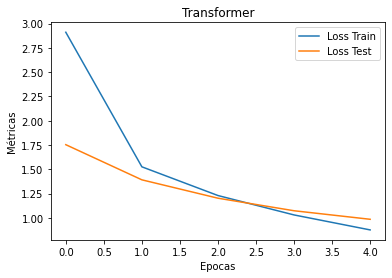

In [13]:
plt.plot(history.history["loss"], label="Loss Train")
plt.plot(history.history["val_loss"], label="Loss Test")

plt.title('Transformer')
plt.ylabel('Métricas')
plt.xlabel('Epocas')
plt.legend(loc='best')

In [14]:
def translate(input_sentence):
    if type(input_sentence) != str:
        return TypeError("input_sentence must be a str")
    else:
        # Se construye la tokenización del input
        input_sentence = input_sentence.split()
        tokenized_input_sentence = [source_token_dict_inv[1]]
        
        for i in range(len(input_sentence)):
            tokenized_input_sentence.append(input_sentence[i])

        tokenized_input_sentence = tokenized_input_sentence + ['<TOKEN_NULO>']*(max_len-len(tokenized_input_sentence))
        tokenized_input_sentence[len(input_sentence)+1] = source_token_dict_inv[2]
        tokenized_input_sentence = [source_token_dict[word] for word in tokenized_input_sentence]
        #Se construye la tokenización de la predicción
        decoded_sentence = target_token_dict_inv[1]
        for i in range(max_len):
            tokenized_target_sentence = decoded_sentence.split() + ['<TOKEN_NULO>']*(max_len-len(decoded_sentence.split()))
            tokenized_target_sentence = [target_token_dict[word] for word in tokenized_target_sentence]
            predictions = transformer([np.array([tokenized_input_sentence]),
                                       np.array([tokenized_target_sentence])])
            sampled_token_index = np.argmax(predictions[0][i])
            sampled_token = target_token_dict_inv[sampled_token_index]
            decoded_sentence += " " + sampled_token
            if sampled_token == target_token_dict_inv[2]:
                return(decoded_sentence)
        return(decoded_sentence)

In [15]:
translate("the world is in danger")

'<TOKEN_INICIO> el mundo está en el banco. <TOKEN_FIN>'

In [16]:
translate("tom")

'<TOKEN_INICIO> tom es una vez. <TOKEN_FIN>'

In [17]:
translate("the game is in danger")

'<TOKEN_INICIO> el juego está en el banco. <TOKEN_FIN>'

In [18]:
translate("what did she do today?")

'<TOKEN_INICIO> ¿qué hizo eso hoy? <TOKEN_FIN>'

In [19]:
translate("don't let them fool you")

'<TOKEN_INICIO> no dejes que te va a ti mismo. <TOKEN_FIN>'

In [20]:
translate("her speech moved the audience")

'<TOKEN_INICIO> su discurso se quedó al árbol. <TOKEN_FIN>'

In [21]:
translate("home")

'<TOKEN_INICIO> a casa de casa. <TOKEN_FIN>'

In [22]:
translate("sun in the beach")

'<TOKEN_INICIO> lleva en la pared. <TOKEN_FIN>'

In [23]:
translate("this dog is my friend")

'<TOKEN_INICIO> este perro es mi amigo de mi amigo. <TOKEN_FIN>'

In [24]:
translate("he's always on time.")

'<TOKEN_INICIO> él siempre está en tiempo. <TOKEN_FIN>'

In [25]:
translate("i almost never remember dreams.")

'<TOKEN_INICIO> casi nunca he oído hoy. <TOKEN_FIN>'

In [26]:
translate("do you need to leave today?")

'<TOKEN_INICIO> ¿sabes que ir hoy? <TOKEN_FIN>'

In [27]:
translate("you reap what you sow")

'<TOKEN_INICIO> tú tú tú lo que estás mintiendo. <TOKEN_FIN>'

In [28]:
translate("should i go?")

'<TOKEN_INICIO> ¿te debo ir? <TOKEN_FIN>'

In [29]:
for i in range(len(x1_test)):
    sequence = x1_test[i]
    decode_seq = [source_token_dict_inv[j] for j in x1_test[i]]
    decode_seq = decode_seq[1:]
    decode_seq = [word for word in decode_seq if word[-1]!= '>']
    print(" ".join(decode_seq))
    print(translate(" ".join(decode_seq)))
    print('\n')
    if i == 200:
      break

you reap what you sow.
<TOKEN_INICIO> tú no te va lo que pasó. <TOKEN_FIN>


you need a job.
<TOKEN_INICIO> necesitas un trabajo. <TOKEN_FIN>


let's make it brief.
<TOKEN_INICIO> vamos a hacer extraño. <TOKEN_FIN>


keep children away from the pond.
<TOKEN_INICIO> quédate los niños del río. <TOKEN_FIN>


he accused the man of stealing.
<TOKEN_INICIO> él dejó el hombre de que se fue. <TOKEN_FIN>


there's something i should tell you.
<TOKEN_INICIO> hay algo que debería decir que te lo hiciera. <TOKEN_FIN>


she didn't read the book.
<TOKEN_INICIO> ella no lee el libro. <TOKEN_FIN>


turn on your headlights.
<TOKEN_INICIO> pon los ojos en los demás. <TOKEN_FIN>


they consider him unfit for the job.
<TOKEN_INICIO> ellos no lo hicieron para el trabajo. <TOKEN_FIN>


he sang some old songs.
<TOKEN_INICIO> él cantó algo de nueva canción. <TOKEN_FIN>


should i go?
<TOKEN_INICIO> ¿te debo ir? <TOKEN_FIN>


we danced all night long.
<TOKEN_INICIO> fuimos toda la noche. <TOKEN_FIN>


tom neve